# Optimal number of clusters

In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

## Constants

In [2]:
n_spec_bin_03 = 181_850

## Data ingestion

In [3]:
def data_ingestion(metric, run_id, bin_id, n_segments, explanations_dir, spectra_dir):
    """
    Function to load the data for a given metric and run_id.
    """

    data_dict = {
        "metric": metric,
        "run_id": run_id,
        "weights": None,
        "norm_weights": None,
        "unique_weights": None,
        "norm_unique_weights": None,
    }

    data_dict["weights"] = np.load(
        f"{explanations_dir}/{bin_id}/"
        f"{data_dict['metric']}/"
        f"weights_{data_dict['run_id']}.npy"
    )

    data_dict["norm_weights"] = clustering.normalize_weights_l2_abs(
        data_dict["weights"]
    )

    data_dict["unique_weights"] = clustering.compress_weights_per_segments(
        weights=data_dict["weights"],
        n_segments=n_segments
    )

    data_dict["norm_unique_weights"] = clustering.normalize_weights_l2_abs(
        data_dict["unique_weights"]
    )

    return data_dict

## Clustering

In [4]:
def plot_inertias_silhouettes(
    inertias,
    silhouettes,
    n_clusters,
    subtitle='',
):
    fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
    axs[0].plot(range(2, n_clusters), inertias, '-o')
    axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

    # Add major and minor ticks
    for ax in axs:
        # major ticks every 2
        ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
        # minor ticks every 1
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', alpha=0.4)
    # Add labels
    axs[0].set_ylabel("Inertia")
    axs[1].set_ylabel("Silhouette Score")

    # Shared x-label and title
    fig.supxlabel("Number of Clusters")
    fig.suptitle(
        "Clustering Metrics vs Number of Clusters\n"
        f"{subtitle}"
    )

    return fig, axs


## PCA

In [5]:
def pca_variance_analysis(X: np.ndarray, variance_threshold: float = 0.95):
    """
    Performs PCA on the input matrix and determines the number of components
    required to retain a specified amount of variance.

    Parameters
    ----------
    X : np.ndarray
        Input data matrix of shape (n_samples, n_features).
    variance_threshold : float
        The target cumulative explained variance (default is 0.95).

    Returns
    -------
    n_components_needed : int
        Number of PCA components needed to explain the desired variance.
    explained_variance_ratio : np.ndarray
        Cumulative explained variance ratio for each principal component.
    X_pca : np.ndarray
        Data projected into the PCA space (all components).
    """
    pca = PCA()
    X_pca = pca.fit_transform(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components_needed = np.searchsorted(cumulative_variance, variance_threshold) + 1
    
    return n_components_needed, cumulative_variance, X_pca

In [6]:
def plot_pca_variance(
    cumulative_variance,
    n_components_needed,
    variance_threshold=0.95,
    figsize=(10, 6),
):
    """
    Plots the cumulative explained variance ratio from PCA.

    Parameters
    ----------
    cumulative_variance : np.ndarray
        Cumulative explained variance ratio for each principal component.
    n_components_needed : int
        Number of PCA components needed to explain the desired variance.
    variance_threshold : float
        The target cumulative explained variance (default is 0.95).
    """
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(cumulative_variance, marker='o', linestyle='--')
    
    ax.axhline(
        y=variance_threshold, color='r', linestyle='--',
        label=f'{variance_threshold:.0%} Variance Threshold'
    )

    ax.axvline(
        x=n_components_needed, color='g', linestyle='--',
        label=f'Components Needed: {n_components_needed}'
    )

    ax.set_title('PCA Cumulative Explained Variance')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance Ratio')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    return fig, ax


# Directories

In [7]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")

# MSE noRel 100

## Data ingestion

In [8]:
mse_noRel100_dict = data_ingestion(
    metric="mse_noRel100",
    # run_id="20250427190650_uniform_5000_scale",
    run_id="20250514144513_uniform_150_scale_0.9",
    bin_id=bin_id,
    n_segments=150,
    explanations_dir=explanations_dir,
    spectra_dir=spectra_dir
)

Base size: 25, Residual size: 23
New number of segments: 151


In [9]:
mse_noRel100_dict.keys()

dict_keys(['metric', 'run_id', 'weights', 'norm_weights', 'unique_weights', 'norm_unique_weights'])

## Clustering

In [10]:
n_clusters = 24

inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=mse_noRel100_dict["norm_unique_weights"],
    n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)
mse_noRel100_dict["inertias"] = inertias
mse_noRel100_dict["silhouette_scores"] = silhouette_scores
# Run time: 32.79 seconds

Run time: 32.31 seconds


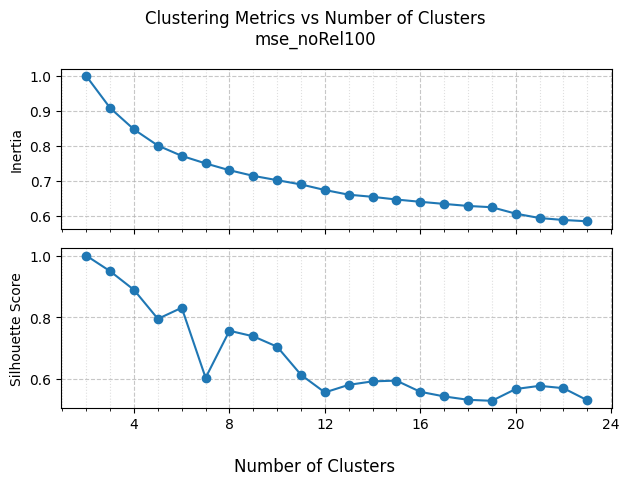

In [12]:
subptitle = (
    f"{mse_noRel100_dict['metric']}"
)
fig, axs = plot_inertias_silhouettes(
    inertias=mse_noRel100_dict["inertias"],
    silhouettes=mse_noRel100_dict["silhouette_scores"],
    n_clusters=mse_noRel100_dict["inertias"].shape[0] + 2,
    subtitle=subptitle
)

plt.tight_layout()
plt.show()


## Top 1% Anomalies

In [13]:
n_clusters = 24
n_top_1_percent = int(0.01 * n_spec_bin_03)
X = mse_noRel100_dict["norm_unique_weights"][-1*n_top_1_percent:]
inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=X,
    n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)
mse_noRel100_dict["inertias_1_percent"] = inertias
mse_noRel100_dict["silhouette_scores_1_percent"] = silhouette_scores

Run time: 3.47 seconds


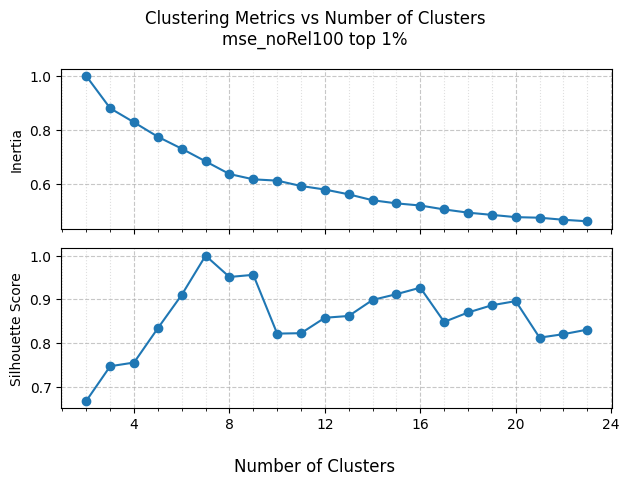

In [14]:
subptitle = (
    f"{mse_noRel100_dict['metric']} top 1%"
)
fig, axs = plot_inertias_silhouettes(
    inertias=mse_noRel100_dict["inertias_1_percent"],
    silhouettes=mse_noRel100_dict["silhouette_scores_1_percent"],
    n_clusters=mse_noRel100_dict["inertias_1_percent"].shape[0] + 2,
    subtitle=subptitle
)

plt.tight_layout()
plt.show()


## PCA

Number of components needed to explain  90.0% variance: 35


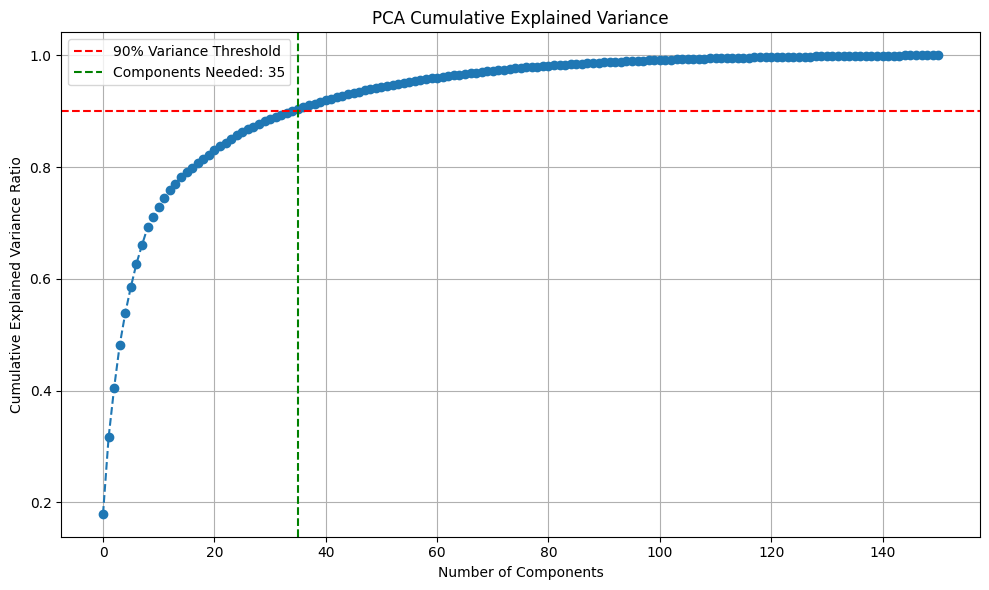

In [24]:
X = mse_noRel100_dict["norm_unique_weights"][-1*n_top_1_percent:]

variance_threshold=0.9
n_components, cumvar, X_pca = pca_variance_analysis(
    X,
    variance_threshold
)

print(
    "Number of components needed to explain "
    f" {variance_threshold*100}% variance: {n_components}"
)

fig, ax = plot_pca_variance(
    cumvar,
    n_components,
    variance_threshold=variance_threshold,
    # figsize=(10, 6),
)


# MSE filter 250 kms no rel 97

## Data ingestion

In [16]:
mse_filter_250kms_noRel97_dict = data_ingestion(
    metric="mse_filter_250kms_noRel97",
    # run_id="20250427105355_uniform_5000_scale",
    run_id="20250514105957_uniform_150_scale_0.9",
    bin_id=bin_id,
    n_segments=150,
    explanations_dir=explanations_dir,
    spectra_dir=spectra_dir
)

Base size: 25, Residual size: 23
New number of segments: 151


## Clsutering

In [17]:
n_clusters = 24

inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=mse_filter_250kms_noRel97_dict["norm_unique_weights"],
    n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)
mse_filter_250kms_noRel97_dict["inertias"] = inertias
mse_filter_250kms_noRel97_dict["silhouette_scores"] = silhouette_scores
# Run time: 32.79 seconds


Run time: 32.80 seconds


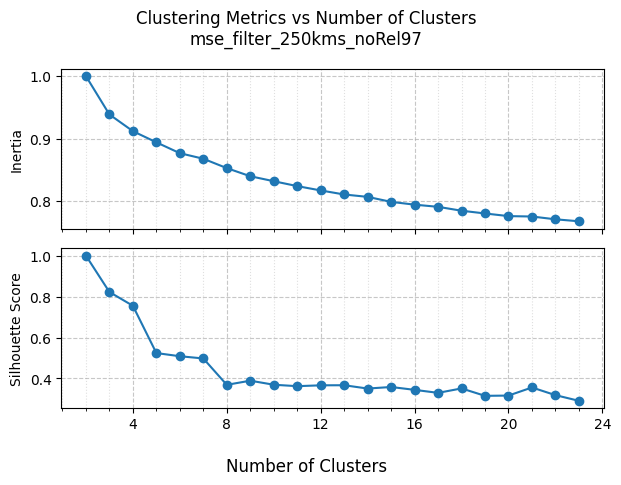

In [18]:
subptitle = (
    f"{mse_filter_250kms_noRel97_dict['metric']}"
)
fig, axs = plot_inertias_silhouettes(
    inertias=mse_filter_250kms_noRel97_dict["inertias"],
    silhouettes=mse_filter_250kms_noRel97_dict["silhouette_scores"],
    n_clusters=mse_filter_250kms_noRel97_dict["inertias"].shape[0] + 2,
    subtitle=subptitle
)

plt.tight_layout()
plt.show()



## Top 1% Anomalies


Run time: 3.50 seconds


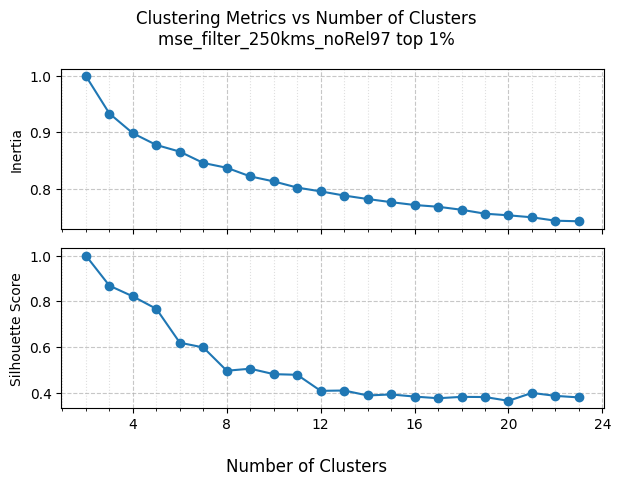

In [19]:
n_clusters = 24
n_top_1_percent = int(0.01 * n_spec_bin_03)
X = mse_filter_250kms_noRel97_dict["norm_unique_weights"][-1*n_top_1_percent:]
inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=X,
    n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)
mse_filter_250kms_noRel97_dict["inertias_1_percent"] = inertias
mse_filter_250kms_noRel97_dict["silhouette_scores_1_percent"] = silhouette_scores
subptitle = (
    f"{mse_filter_250kms_noRel97_dict['metric']} top 1%"
)
fig, axs = plot_inertias_silhouettes(
    inertias=mse_filter_250kms_noRel97_dict["inertias_1_percent"],
    silhouettes=mse_filter_250kms_noRel97_dict["silhouette_scores_1_percent"],
    n_clusters=mse_filter_250kms_noRel97_dict["inertias_1_percent"].shape[0] + 2,
    subtitle=subptitle
)

plt.tight_layout()
plt.show()


## PCA


Number of components needed to explain  80.0% variance: 44


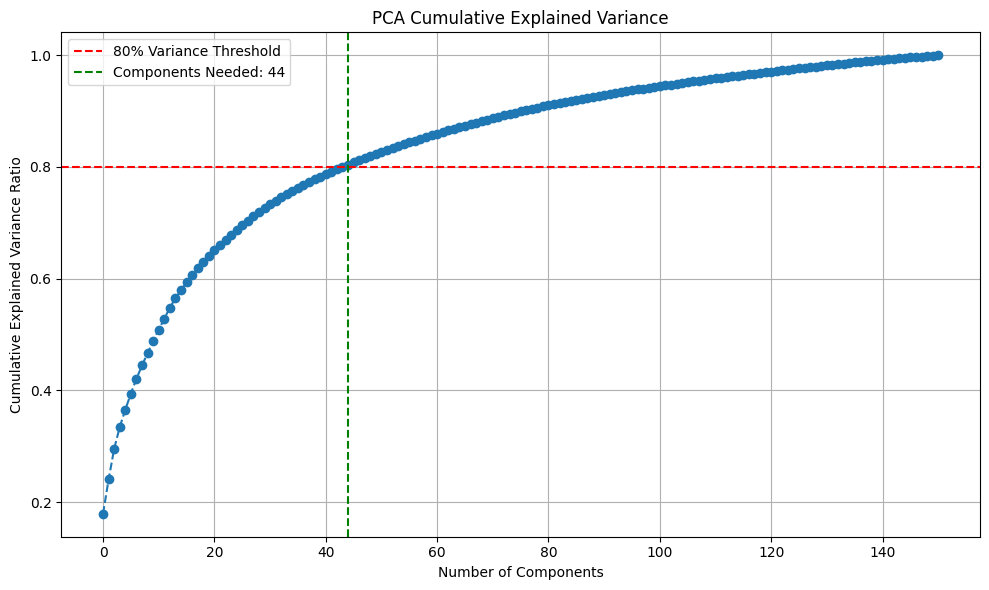

In [25]:
X = mse_filter_250kms_noRel97_dict["norm_unique_weights"]
# [-1*n_top_1_percent:]

variance_threshold=0.8
n_components, cumvar, X_pca = pca_variance_analysis(
    X,
    variance_threshold
)

print(
    "Number of components needed to explain "
    f" {variance_threshold*100}% variance: {n_components}"
)

fig, ax = plot_pca_variance(
    cumvar,
    n_components,
    variance_threshold=variance_threshold,
    # figsize=(10, 6),
)